## Example

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cmass.lightcone import lc

In [2]:


def split_galid(gid):
    return np.divmod(gid, 2**((gid.itemsize-1)*8))

In [3]:
# how many galaxies we randomly generate per volume
N = 3000000

# where mask .ply files and redshift histogram are stored
boss_dir = '/anvil/scratch/x-mho1/cmass-ili/obs'

# scale factors, need to be monotonically decreasing
snap_times = [0.7, 0.65, 0.6, ]

# some randomness
rng = np.random.default_rng(137)

In [4]:


# make the mask (this is a bit expensive, so we do it outside the lightcone so it can be re-used)
print('Starting mask loading...')
m = lc.Mask(boss_dir=boss_dir, veto=False)
print('...finished mask loading')

Starting mask loading...
...finished mask loading


In [5]:


def hod_fct(
        snap_idx: int,
        hlo_idx: np.ndarray[np.uint64],
        z: np.ndarray[np.float64]) -> tuple:
    """ This is the callback function for the HOD

    The arguments are
    - snap_idx: an integer going into the snapshots list
    - hlo_idx: an array of integer indices going into the halo arrays
    - z: an array of doubles corresponding to the redshifts at which halos intersect lightcone

    This function is expected to return the following:
    - hlo_idx: a [N] array of integer indices going into the arrays *passed as inputs to this function*
               So these *do not* correspond to the halo indices that came as inputs!
    - delta_x: a [N,3] array of galaxy position offsets from their host halo centers,
               comoving Mpc/h
    - delta_v: a [N,3] array of galaxy velocity offsets from their host halo velocities,
               physical km/s

    NOTE that this can be any callable as usual,
         so you can use any object as long as it implements the __call__ method
    """

    # as an example, only halos with certain redshifts get galaxies. Each gets a pair of galaxies.
    # I set the delta_x and delta_v very small so it should be possible to see these pairs in the output
    hlo_idx_out = np.arange(0, len(hlo_idx), dtype=np.uint64)
    select = np.fabs(np.sin(50.0*z)) < 0.2
    hlo_idx_out = np.repeat(hlo_idx_out[select], 2)
    delta_x = (rng.random((len(hlo_idx_out), 3))-0.5) * 0.01
    delta_v = (rng.random((len(hlo_idx_out), 3))-0.5) * 1.0

    return hlo_idx_out, delta_x, delta_v


# run the constructor
l = lc.Lightcone(
    mask=m,
    Omega_m=0.3, zmin=0.40, zmax=0.65, snap_times=snap_times,
    boss_dir=None,  # NOTE setting to None here disables n(z) downsampling now
    verbose=True
)

# set the HOD function
l.set_hod(hod_fct)

process_times
interpolate_chi_z


In [6]:
# add some snapshots
for snap_idx, a in enumerate(snap_times):
    xhlo = rng.random((N, 3)) * 3e3
    vhlo = (rng.random((N, 3))-0.5) * 300
    l.add_snap(snap_idx, xhlo, vhlo)

	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 0
	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 1
	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 2


In [7]:
xhlo.dtype, vhlo.dtype, xhlo.shape, vhlo.shape

(dtype('float64'), dtype('float64'), (3000000, 3), (3000000, 3))

In [8]:
ra, dec, z, galid = l.finalize()

galsnap, galidx = split_galid(galid)
print(f'{galsnap.min()} <= galsnap <= {galsnap.max()}')
print(f'{galidx.min()} <= galidx <= {galidx.max()}')

fibcoll
0 <= galsnap <= 2
0 <= galidx <= 43483


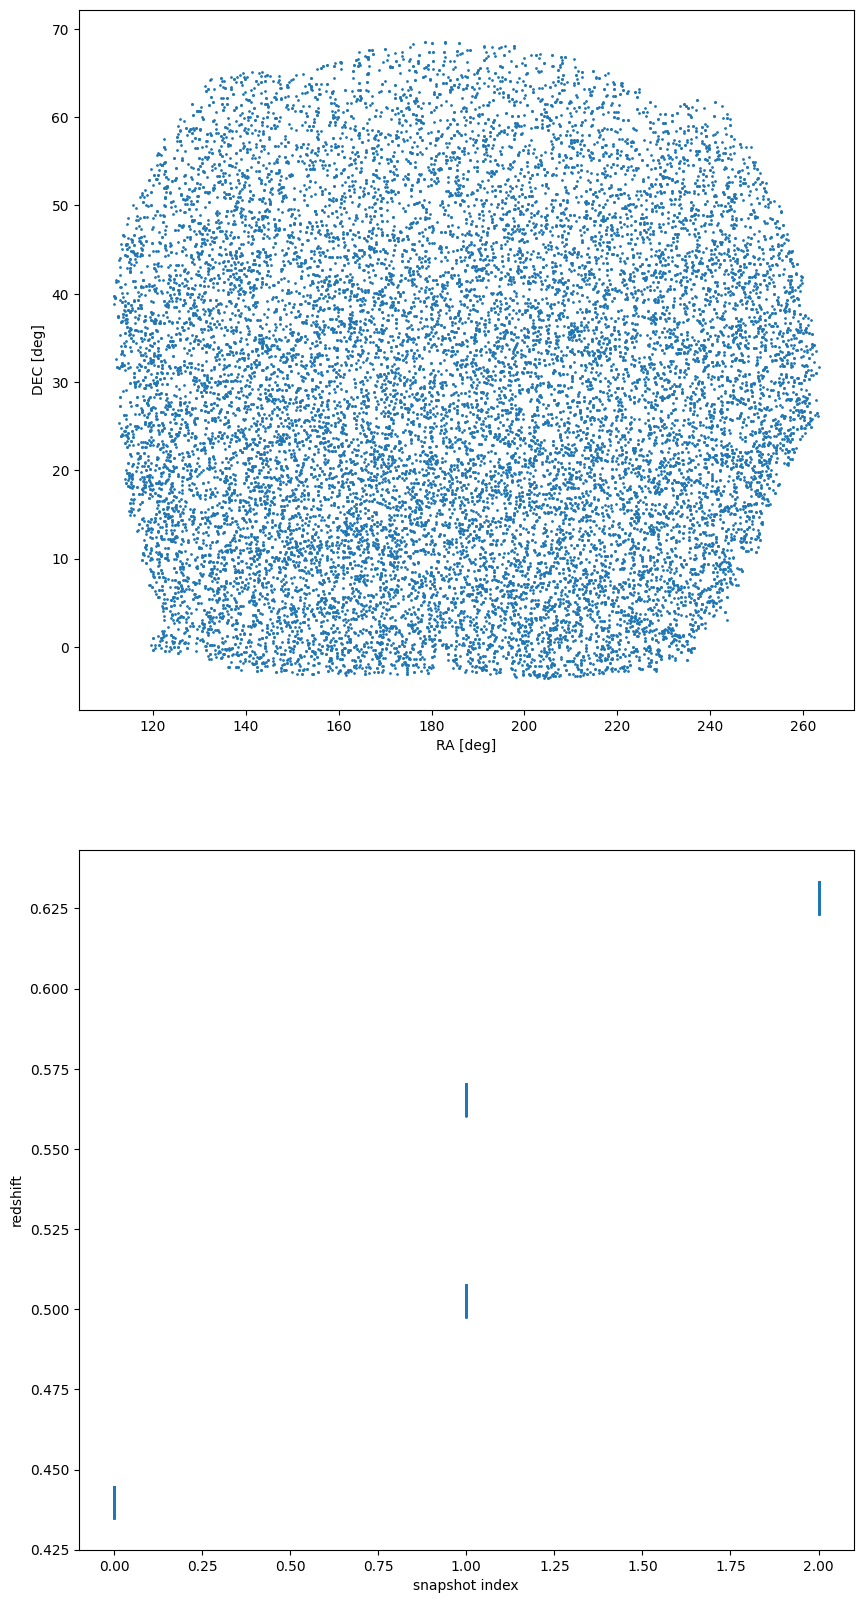

In [9]:

# check if mask is working correctly
fig, ax = plt.subplots(figsize=(10, 20), nrows=2)
ax_mask = ax[0]
ax_snap = ax[1]
choose = (z > 0.5) * (z < 0.6)

ax_mask.plot(ra[choose], dec[choose], linestyle='none',
             marker='o', markersize=1)
ax_mask.set_xlabel('RA [deg]')
ax_mask.set_ylabel('DEC [deg]')

ax_snap.plot(galsnap, z, linestyle='none', marker='o', markersize=1)
ax_snap.set_xlabel('snapshot index')
ax_snap.set_ylabel('redshift')
plt.show()

## Real data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

In [2]:
from omegaconf import OmegaConf
from cmass.infer.loaders import get_cosmo
wdir = '/anvil/scratch/x-mho1/cmass-ili'

nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 2000

simdir = join(wdir, nbody, sim, f'L{L:d}-N{N:d}', str(lhid))

cosmo = get_cosmo(simdir)
cfg = OmegaConf.load(join(simdir, 'config.yaml'))

In [3]:
from cmass.bias.apply_hod import load_snapshot

hpos, hvel, hmass, hmeta = load_snapshot(simdir, 0.66666)

print(hpos.shape, hvel.shape, hmass.shape)

(17017949, 3) (17017949, 3) (17017949,)


In [4]:
from cmass.lightcone import lc
boss_dir = '/anvil/scratch/x-mho1/cmass-ili/obs'
maskobs = lc.Mask(boss_dir=boss_dir, veto=False)
snap_times = sorted(cfg.nbody.asave)[::-1]  # decreasing order
snap_times = snap_times[4:]
lightcone = lc.Lightcone(
    boss_dir=None,
    mask=maskobs,
    Omega_m=cfg.nbody.cosmo[0],
    zmin=0.4,
    zmax=0.7,
    snap_times=snap_times,
    verbose=True,
    augment=0,
    seed=42
)
print(snap_times)

[0.68677, 0.66666, 0.64655, 0.62644, 0.60633, 0.58622]process_times

interpolate_chi_z


In [5]:
from cmass.bias.apply_hod import run_snapshot

# rng = np.random.default_rng(137)


# def hod_fct(
#     snap_idx: int,
#     hlo_idx: np.ndarray[np.uint64],
#     z: np.ndarray[np.float64]
# ) -> tuple:
#     join
#     hlo_idx_out = np.arange(0, len(hlo_idx), dtype=np.uint64)
#     select = np.fabs(np.sin(50.0*z)) < 0.2
#     hlo_idx_out = np.repeat(hlo_idx_out[select], 2)
#     delta_x = (rng.random((len(hlo_idx_out), 3))-0.5) * 0.01
#     delta_v = (rng.random((len(hlo_idx_out), 3))-0.5) * 1.0

#     return hlo_idx_out, delta_x, delta_v
import numpy as np
from scipy.special import erf


def sample_centrals(log_halo_mass, logMmin=12.0, sigma_logM=0.25,):
    mean_ncen = 0.5 * \
        (1 + erf((log_halo_mass - logMmin) / (np.sqrt(2) * sigma_logM)))
    randoms = np.random.random(len(log_halo_mass))
    centrals_mask = (randoms < mean_ncen).astype(bool)
    return centrals_mask


def M_i(z, M_i_pivot, mu_i_p, z_pivot, ):
    # + mu_i_p_sq * ((1 / (1 + z)) - (1 / (1 + z_pivot))**2)
    return M_i_pivot + mu_i_p * ((1 / (1 + z)) - (1 / (1 + z_pivot)))


class HODEngine():
    def __init__(self, cfg, snap_times, simdir, params):
        self.cfg = cfg
        self.snap_times = snap_times
        self.simdir = simdir
        self.params = params

    def __call__(self, snap_idx, hlo_idx, z):
        a = self.snap_times[snap_idx]

        hpos, hvel, hmass, hmeta = load_snapshot(self.simdir, a)
        # m = hmass > 13
        hpos = hpos
        hvel = hvel
        hmass = hmass

        hpos = hpos[hlo_idx]
        hvel = hvel[hlo_idx]
        hmass = hmass[hlo_idx]

        logMmin_z = M_i(z, *self.params[:-1])
        mask_centrals_vary = sample_centrals(
            hmass, logMmin=logMmin_z, sigma_logM=self.params[-1],)

        gpos = hpos[mask_centrals_vary]
        gvel = hvel[mask_centrals_vary]
        ghost = np.argwhere(mask_centrals_vary).flatten()
        dgpos = np.zeros_like(gpos)
        dgvel = np.zeros_like(gvel)

        # gpos, gvel, gmeta = run_snapshot(hpos, hvel, hmass, a, self.cfg)
        # ghost = gmeta['hostid']
        # dgpos = gpos - hpos[ghost]
        # dgvel = gvel - hvel[ghost]

        ghost = ghost.astype(np.uint64)
        dgpos = dgpos.astype(np.float64)
        dgvel = dgvel.astype(np.float64)
        return ghost, dgpos, dgvel


params = [13.2, -23., 0.61, 0.38]
hod_fct = HODEngine(cfg, snap_times, simdir, params)

# set the HOD function
lightcone.set_hod(hod_fct)

In [6]:
# add some snapshots
for snap_idx, a in enumerate(snap_times):
    hpos, hvel, hmass, hmeta = load_snapshot(simdir, a)
    hpos = hpos.astype(np.float64)
    hvel = hvel.astype(np.float64)
    hmass = hmass

    lightcone.add_snap(snap_idx, hpos, hvel)

	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 0
	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 1
	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 2
	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 3
	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 4
	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 5


In [7]:
ra, dec, z, galid = lightcone.finalize()


def split_galid(gid):
    return np.divmod(gid, 2**((gid.itemsize-1)*8))


galsnap, galidx = split_galid(galid)
print(f'{galsnap.min()} <= galsnap <= {galsnap.max()}')
print(f'{galidx.min()} <= galidx <= {galidx.max()}')

fibcoll
0 <= galsnap <= 5
0 <= galidx <= 425891


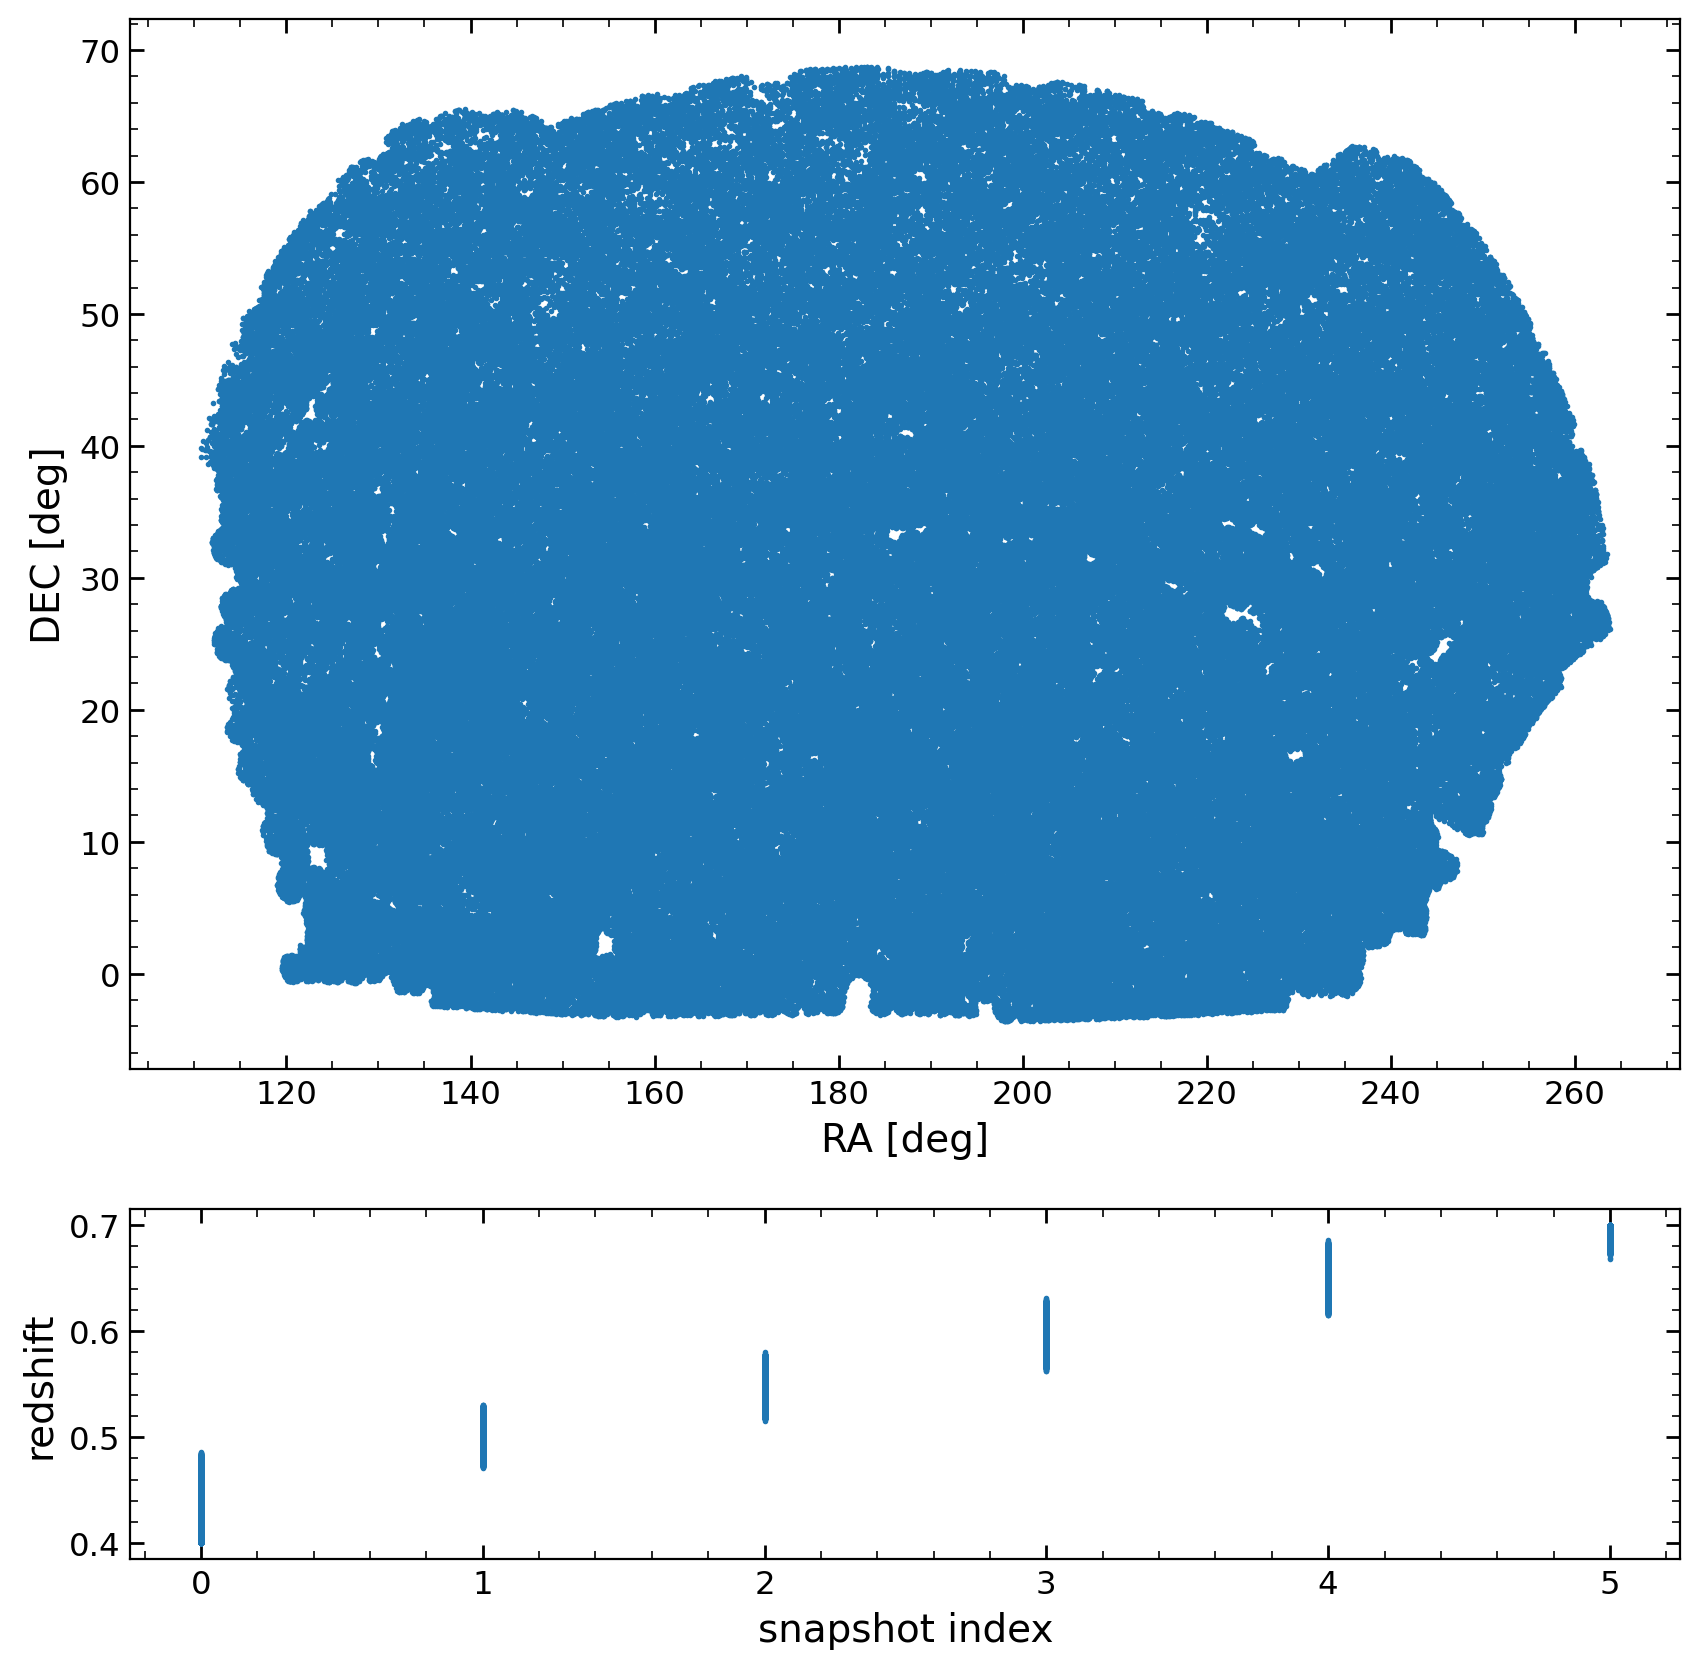

In [8]:

# check if mask is working correctly
fig, ax = plt.subplots(figsize=(10, 10), nrows=2,
                       gridspec_kw={'height_ratios': [3, 1]})
ax_mask = ax[0]
ax_snap = ax[1]
choose = (z > 0.5) * (z < 0.6)

ax_mask.plot(ra[choose], dec[choose], linestyle='none',
             marker='o', markersize=1)
ax_mask.set_xlabel('RA [deg]')
ax_mask.set_ylabel('DEC [deg]')

ax_snap.plot(galsnap, z, linestyle='none', marker='o', markersize=1)
ax_snap.set_xlabel('snapshot index')
ax_snap.set_ylabel('redshift')
plt.show()

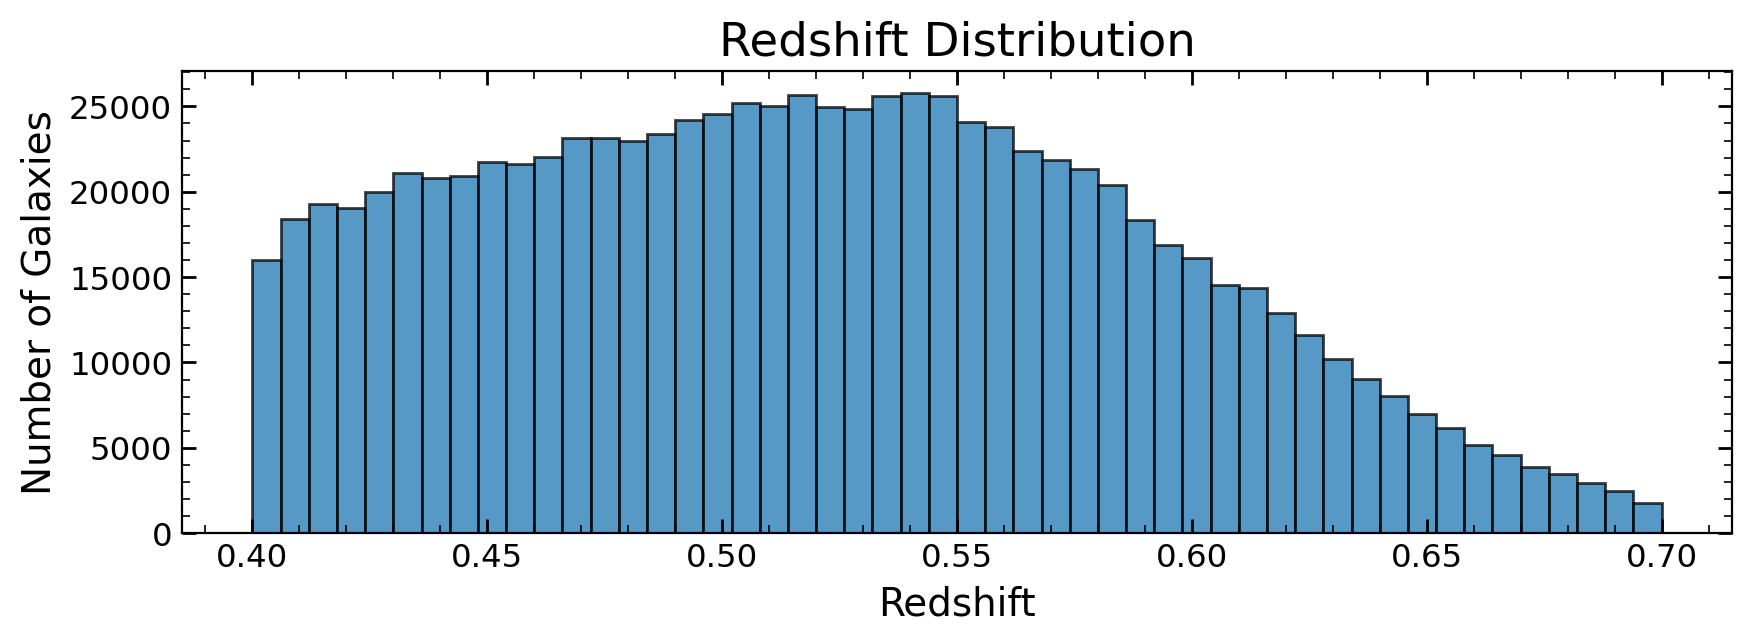

In [9]:
plt.figure(figsize=(10, 3))
plt.hist(z, bins=50, alpha=0.75, edgecolor='black')
plt.xlabel('Redshift')
plt.ylabel('Number of Galaxies')
plt.title('Redshift Distribution')
plt.show()

In [10]:
# Load observations
from cmass.survey.tools import sky_to_xyz


def load_fits(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)
    return gals


zlim = 0.4, 0.7
fields = ['RA', 'DEC', 'Z', 'WEIGHT_SYSTOT', 'WEIGHT_NOZ', 'WEIGHT_CP']

# Load NGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_North.fits')
cmass = load_fits(fname, fields)
nrdz = cmass[['RA', 'DEC', 'Z']].values
mask = (nrdz[:, 2] > zlim[0]) & (nrdz[:, 2] < zlim[1])
nrdz = nrdz[mask]
nxyz = sky_to_xyz(nrdz, cosmo)

# Load SGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_South.fits')
cmass = load_fits(fname, fields)
srdz = cmass[['RA', 'DEC', 'Z']].values
mask = (srdz[:, 2] > zlim[0]) & (srdz[:, 2] < zlim[1])
srdz = srdz[mask]
sxyz = sky_to_xyz(srdz, cosmo)

print(len(nrdz), len(srdz))

579089 213205


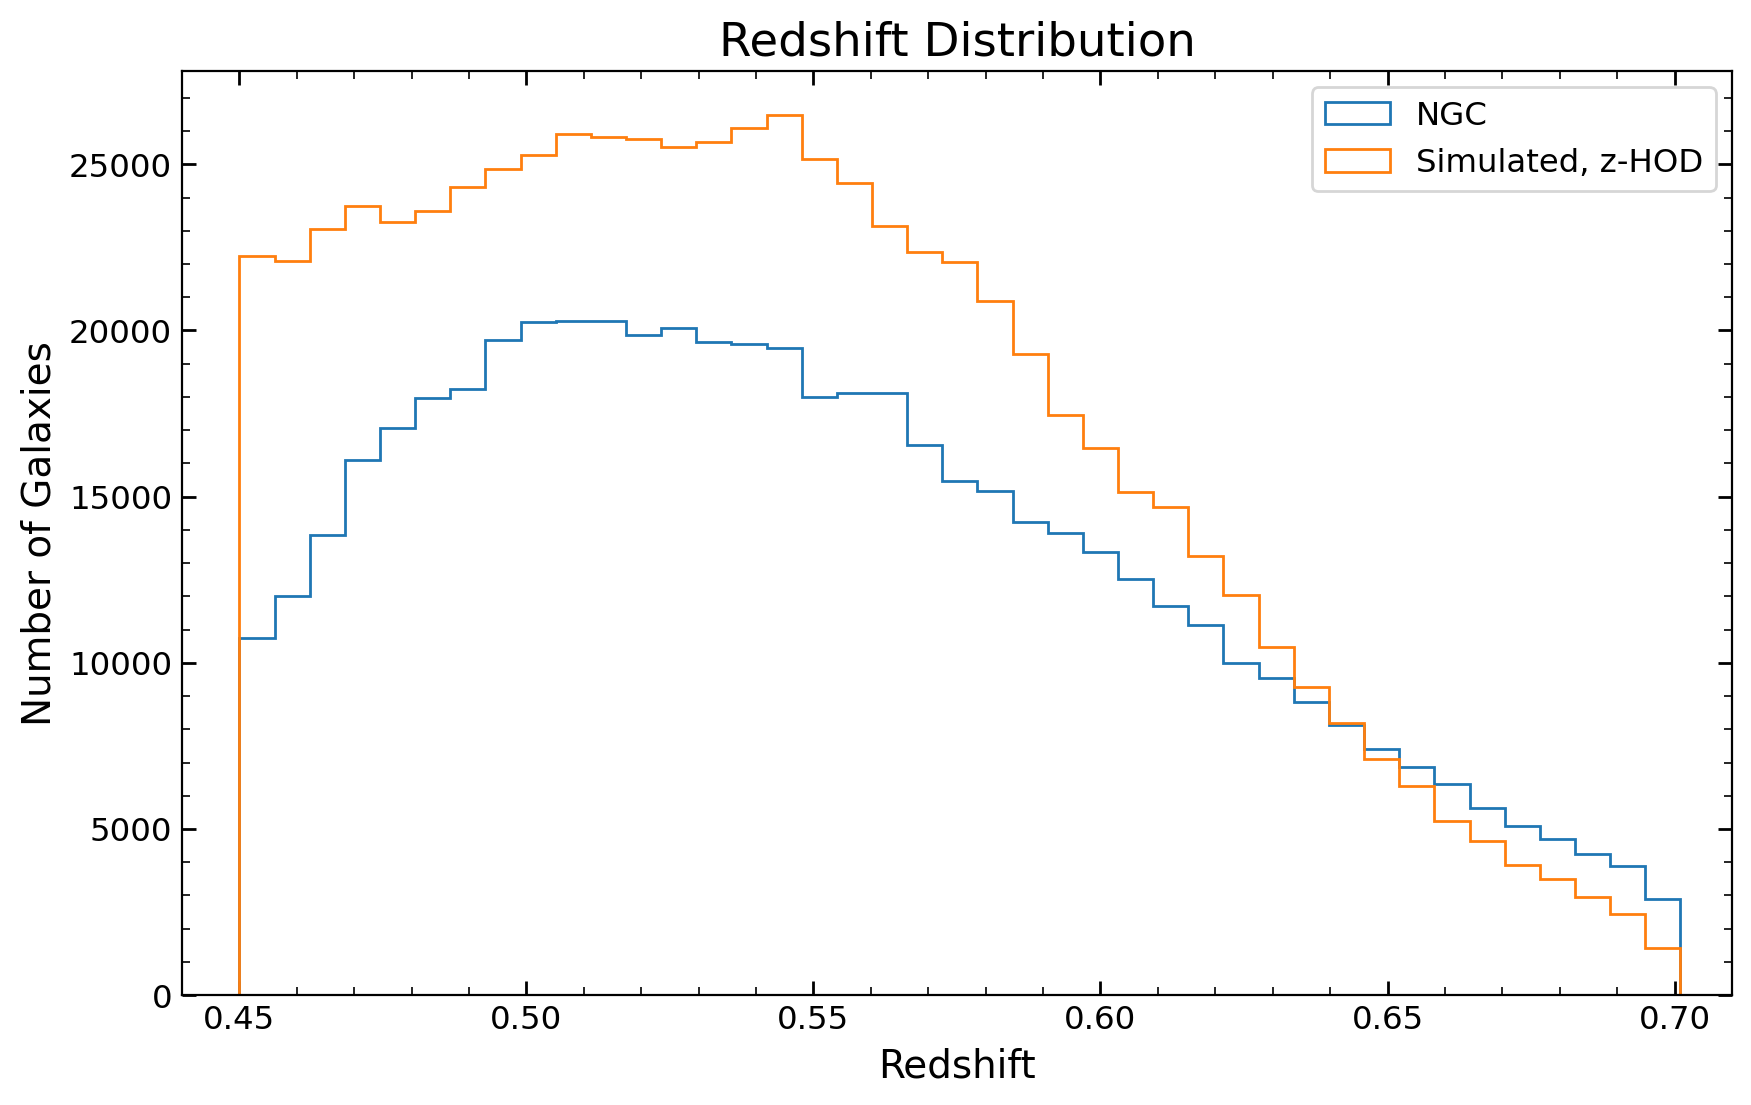

In [ ]:
plt.figure(figsize=(10, 6))

b = np.linspace(0.45, 0.75, 50)
# plt.hist(z, bins=b, histtype='step', label='Simulated, no n(z)')
plt.hist(nrdz[:, 2], bins=b, histtype='step', label='NGC')

plt.hist(z, bins=b, histtype='step', label='Simulated, z-HOD')


plt.xlabel('Redshift')
plt.ylabel('Number of Galaxies')
plt.title('Redshift Distribution')
plt.legend()
plt.xlim(0.44, 0.71)
plt.show()

In [ ]:
# Search for the best fit
from scipy.optimize import minimize


def objective(params):
    from cmass.lightcone import lc
    boss_dir = '/anvil/scratch/x-mho1/cmass-ili/obs'
    maskobs = lc.Mask(boss_dir=boss_dir, veto=False)
    snap_times = sorted(cfg.nbody.asave)[::-1]  # decreasing order
    snap_times = snap_times[4:]

    snap_times = snap_times[2:3]
    lightcone = lc.Lightcone(
        boss_dir=None,
        mask=maskobs,
        Omega_m=cfg.nbody.cosmo[0],
        zmin=0.4,
        zmax=0.7,
        snap_times=snap_times,
        verbose=True,
        augment=0,
        seed=42
    )
    print(params)

    # set the HOD function
    hod_fct = HODEngine(cfg, snap_times, simdir, params)
    lightcone.set_hod(hod_fct)

    # add some snapshots
    for snap_idx, a in enumerate(snap_times):
        hpos, hvel, hmass, hmeta = load_snapshot(simdir, a)
        hpos = hpos.astype(np.float64)
        hvel = hvel.astype(np.float64)
        hmass = hmass

        lightcone.add_snap(snap_idx, hpos, hvel)

    # finalize
    ra, dec, z, galid = lightcone.finalize()

    del lightcone, maskobs

    # compare histograms
    histz = np.histogram(z, bins=b)[0]
    hist_nrdz = np.histogram(nrdz[:, 2], bins=b)[0]
    return np.sum((histz - hist_nrdz)**2)


params = [13., -20., 0.61, 0.38]
res = minimize(objective, params, method='Nelder-Mead', options={'maxiter': 10})
print(res)

[ 13.   -20.     0.61   0.38]process_times

interpolate_chi_z
	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 0


: 

## Adapt for scripting

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

In [2]:
from cmass.survey.hodtools import HODEngine
from cmass.lightcone import lc
from cmass.bias.apply_hod import load_snapshot
from omegaconf import OmegaConf
from cmass.infer.loaders import get_cosmo
wdir = '/anvil/scratch/x-mho1/cmass-ili'

nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 2000

simdir = join(wdir, nbody, sim, f'L{L:d}-N{N:d}', str(lhid))

cosmo = get_cosmo(simdir)
cfg = OmegaConf.load(join(simdir, 'config.yaml'))
snap_times = sorted(cfg.nbody.asave)[::-1]  # decreasing order
snap_times = snap_times[4:]

cfg.bias.hod.model = 'zheng07zdep'
cfg.bias.hod.theta['mucen'] = 0
cfg.bias.hod.theta['musat'] = 0
for k, v in cfg.bias.hod.theta.items():
    print(f'{k}: {v}')

hpos, hvel, hmass, hmeta = load_snapshot(simdir, 0.66666)


params = [13.2, -23., 0.61, 0.38]
hod_fct = HODEngine(cfg, snap_times, simdir, params)

logMmin: 12.99819501284159
sigma_logM: 0.12726814955643898
logM0: 13.873648056734076
logM1: 13.61006595909563
alpha: 0.3220462262176259
mucen: 0
musat: 0


In [3]:
ghost, dgpos, dgvel = hod_fct(0, np.arange(
    len(hpos)), np.random.randn(len(hpos))*0.01)

[13:45:33-INFO] Populating HOD...
[13:45:33-INFO] Running populate_hod...
[13:45:33-INFO] Using saved halo concentration...
[13:45:53-INFO] Finished populate_hod... (0m19s)


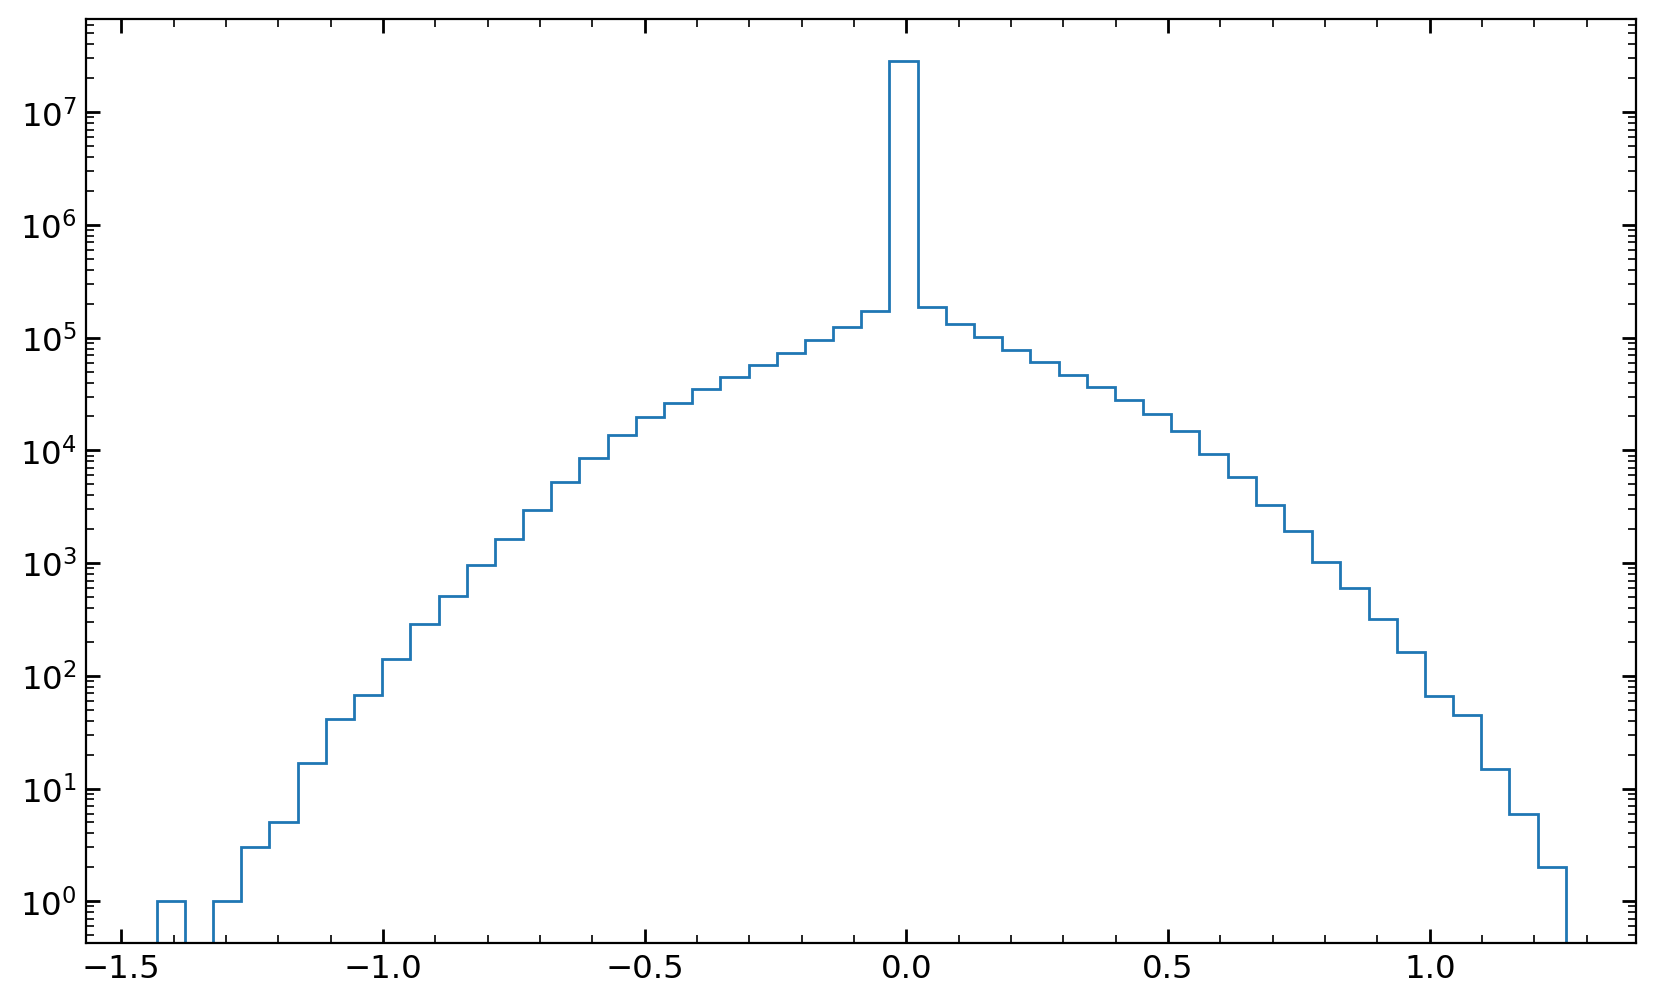

In [ ]:
plt.semilogy()
plt.hist(dgpos.flatten(), bins=50, histtype='step')

## Test HOD variability

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

In [2]:
from omegaconf import OmegaConf
from cmass.infer.loaders import get_cosmo
wdir = '/anvil/scratch/x-mho1/cmass-ili'

nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 0
zmin, zmax = 0.45, 0.7

simdir = join(wdir, nbody, sim, f'L{L:d}-N{N:d}', str(lhid))

cosmo = get_cosmo(simdir)
cfg = OmegaConf.load(join(simdir, 'config.yaml'))
print(cosmo)

[0.1755  0.06681 0.7737  0.8849  0.6641 ]


In [3]:
from cmass.lightcone import lc
boss_dir = '/anvil/scratch/x-mho1/cmass-ili/obs'
maskobs = lc.Mask(boss_dir=boss_dir, veto=False)
snap_times = sorted(cfg.nbody.asave)[::-1]  # decreasing order
snap_times = snap_times[5:6]
lightcone = lc.Lightcone(
    boss_dir=None,
    mask=maskobs,
    Omega_m=cfg.nbody.cosmo[0],
    zmin=zmin,
    zmax=zmax,
    snap_times=snap_times,
    verbose=True,
    augment=0,
    seed=42
)
print(snap_times)

[0.66666]
process_times
interpolate_chi_z


In [4]:
from numpy.random import randn


def hod_fct(
        snap_idx: int,
        hlo_idx: np.ndarray[np.uint64],
        z: np.ndarray[np.float64]) -> tuple:

    # as an example, only halos with certain redshifts get galaxies. Each gets a pair of galaxies.
    # I set the delta_x and delta_v very small so it should be possible to see these pairs in the output
    hlo_idx_out = np.arange(0, len(hlo_idx), dtype=np.uint64)
    delta_x = randn(len(hlo_idx_out), 3) * 0.01
    delta_v = randn(len(hlo_idx_out), 3) * 1.0

    return hlo_idx_out, delta_x, delta_v


lightcone.set_hod(hod_fct)

In [5]:
# add some snapshots
from cmass.bias.apply_hod import load_snapshot

for snap_idx, a in enumerate(snap_times):
    hpos, hvel, hmass, hmeta = load_snapshot(simdir, a)
    hpos = hpos.astype(np.float64)
    hvel = hvel.astype(np.float64)
    hmass = hmass

    lightcone.add_snap(snap_idx, hpos, hvel)

ra, dec, z, galid = lightcone.finalize()


def split_galid(gid):
    return np.divmod(gid, 2**((gid.itemsize-1)*8))


galsnap, galidx = split_galid(galid)
print(f'{galsnap.min()} <= galsnap <= {galsnap.max()}')
print(f'{galidx.min()} <= galidx <= {galidx.max()}')

	remap_snapshot
	choose halos
	callback into python HOD
	choose_galaxies
Done with snap index 0
fibcoll
0 <= galsnap <= 0
3 <= galidx <= 498396


In [6]:
mass = np.empty_like(galidx, dtype=np.float64)

for snap_idx, a in enumerate(snap_times):
    print(f'Loading snapshot {snap_idx}...')
    hpos, hvel, hmass, hmeta = load_snapshot(simdir, a)

    mask = np.isin(galsnap, snap_idx)
    idxs = galidx[mask]
    mass[mask] = hmass[idxs]

Loading snapshot 0...


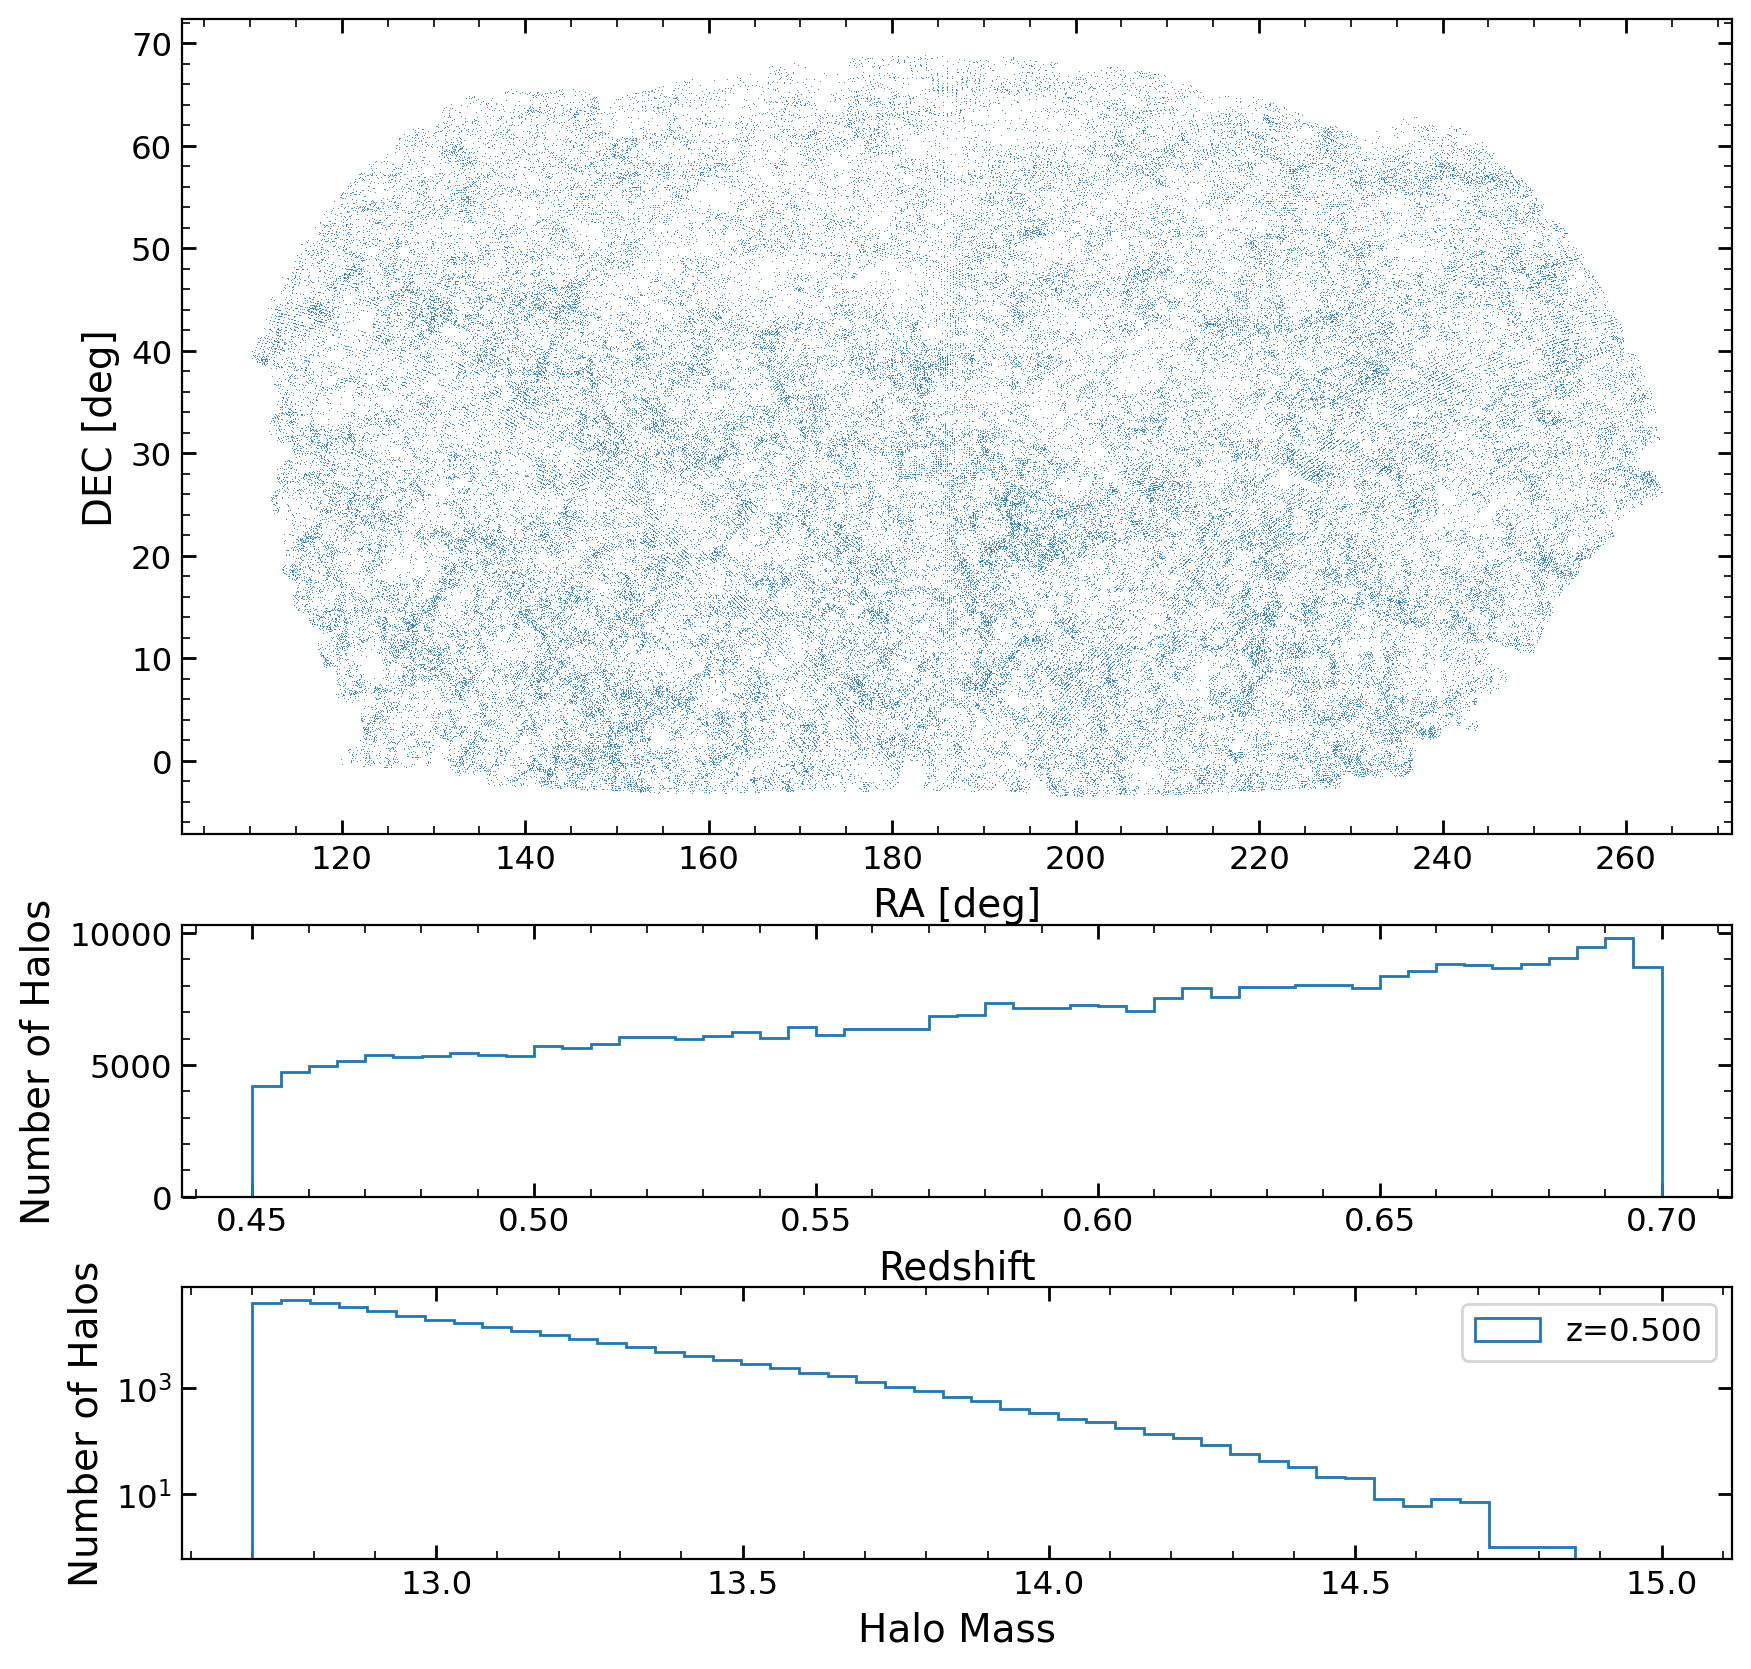

In [7]:
f, axs = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={
                      'height_ratios': [3, 1, 1]})
ax = axs[0]
m = (z > 0.5) * (z < 0.6)
ax.plot(ra[m], dec[m], ',', alpha=0.8)
ax.set(xlabel='RA [deg]', ylabel='DEC [deg]')

ax = axs[1]
ax.hist(z, bins=50, histtype='step')
ax.set(xlabel='Redshift', ylabel='Number of Halos')

ax = axs[2]
ax.semilogy()
be = np.linspace(12.7, 15, 50)
for snap_idx, a in enumerate(snap_times):
    m = galsnap == snap_idx
    ax.hist(mass[m], bins=be, histtype='step', label=f'z={1/a-1:.3f}')
ax.set(xlabel='Halo Mass', ylabel='Number of Halos')
ax.legend(ncol=2)

In [8]:
# Load observations
from cmass.survey.tools import sky_to_xyz


def load_fits(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)
    return gals


zlim = zmin, zmax
fields = ['RA', 'DEC', 'Z', 'WEIGHT_SYSTOT', 'WEIGHT_NOZ', 'WEIGHT_CP']

# Load NGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_North.fits')
cmass = load_fits(fname, fields)
nrdz = cmass[['RA', 'DEC', 'Z']].values
mask = (nrdz[:, 2] > zlim[0]) & (nrdz[:, 2] < zlim[1])
nrdz = nrdz[mask]
nxyz = sky_to_xyz(nrdz, cosmo)

# Load SGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_South.fits')
cmass = load_fits(fname, fields)
srdz = cmass[['RA', 'DEC', 'Z']].values
mask = (srdz[:, 2] > zlim[0]) & (srdz[:, 2] < zlim[1])
srdz = srdz[mask]
sxyz = sky_to_xyz(srdz, cosmo)

print(len(nrdz), len(srdz))

547008 199847


In [9]:

from scipy.special import erf
from cmass.bias.tools.hod_models import logM_i


def cenocc(logM, redshift, params):
    logMmin, sigma_logM, mucen, zpivot = params
    logMmin_z = logM_i(redshift, logMmin, mucen, zpivot)
    mean_ncen = 0.5 * (
        1.0
        + erf((logM - logMmin_z) / (sigma_logM))
    )
    return mean_ncen


def satocc(logM, redshift, pcen, params):
    logM0, logM1, alpha, musat, zpivot = params
    logM0_z = logM_i(redshift, logM0, musat, zpivot)
    logM1_z = logM_i(redshift, logM1, musat, zpivot)

    m = logM > logM0_z
    mean_nsat = np.zeros_like(logM)
    mean_nsat[m] = pcen[m] * (
        (10**logM[m] - 10**logM0_z[m]) / 10**logM1_z[m]
    )**alpha
    return mean_nsat


zpivot = 0.5
logMmin, sigma_logM, mucen = 12.5, 0.5, -20
logM0, logM1, alpha, musat = 13.5, 14.5, 1.1, 0

mean_ncen = cenocc(mass, z, [logMmin, sigma_logM, mucen, zpivot])
mean_nsat = satocc(mass, z, mean_ncen, [logM0, logM1, alpha, musat, zpivot])

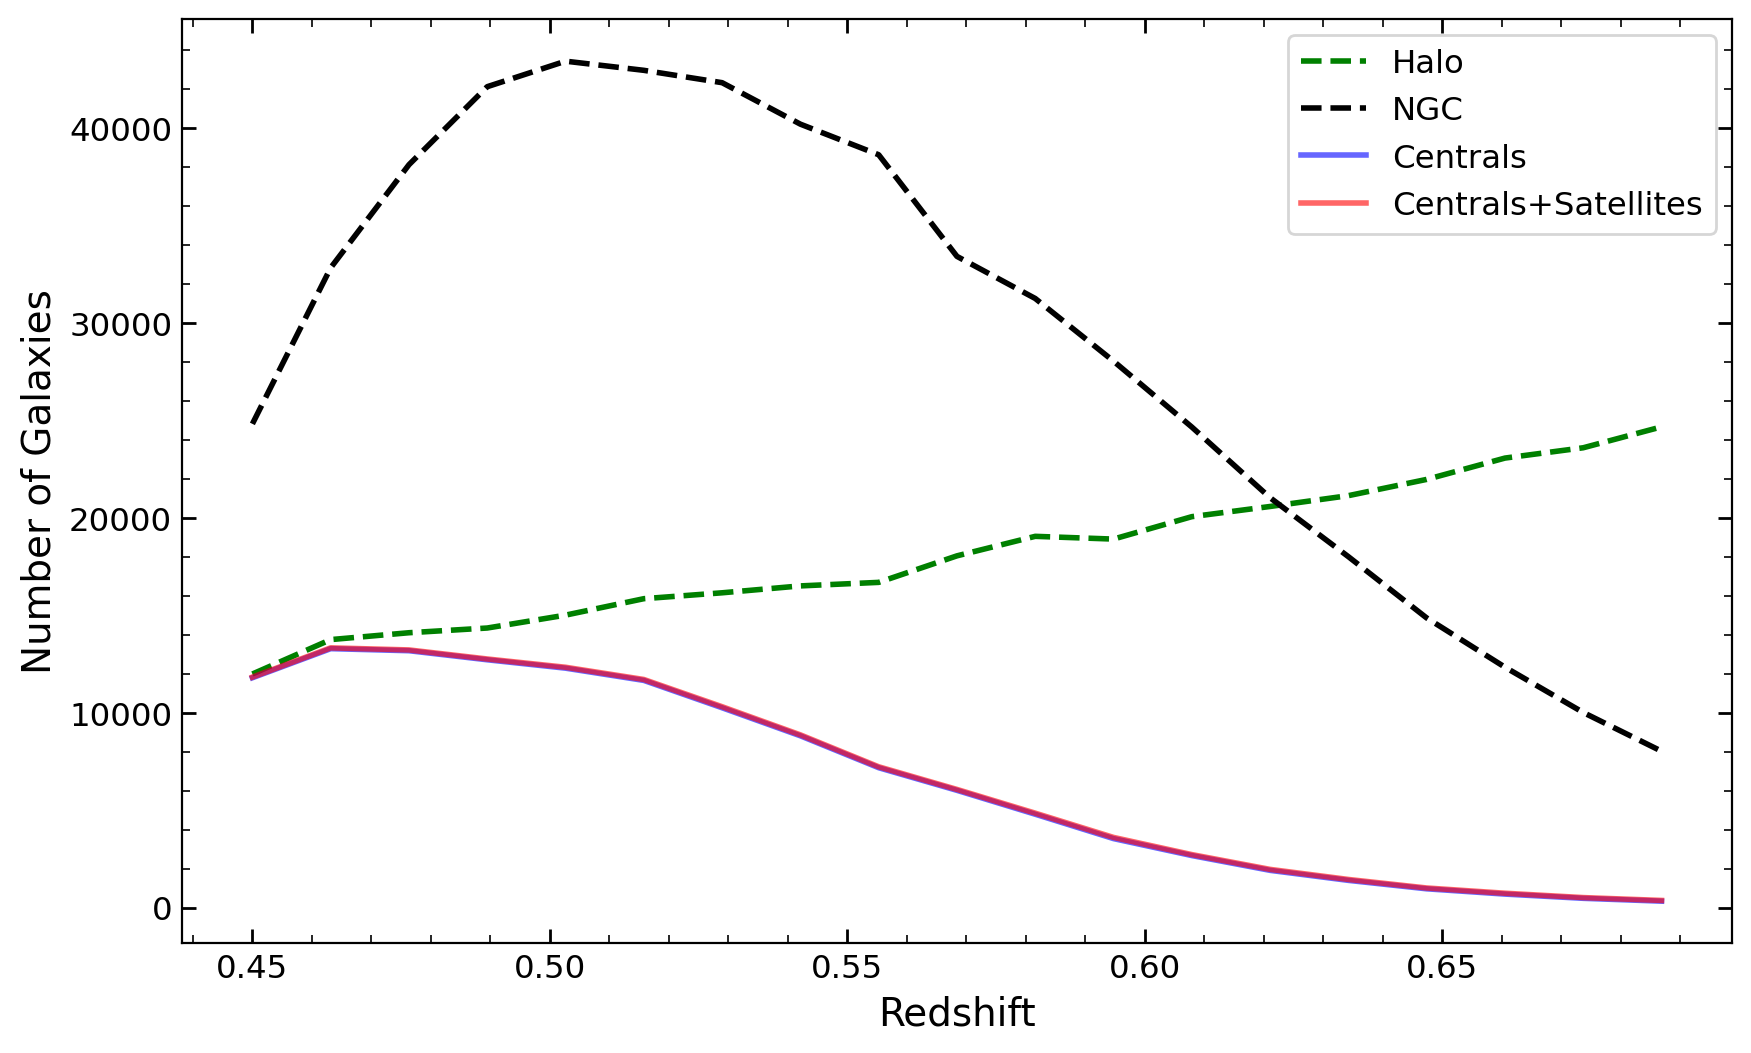

In [10]:
z_bins = np.linspace(zmin, zmax, 20)
halo_hist, _ = np.histogram(z, bins=z_bins)
ncen_hist, _ = np.histogram(z, bins=z_bins, weights=mean_ncen)
nsat_hist, _ = np.histogram(z, bins=z_bins, weights=mean_nsat)
ngc_hist, _ = np.histogram(nrdz[:, 2], bins=z_bins)
bin_width = z_bins[1] - z_bins[0]

f, ax = plt.subplots(figsize=(10, 6))
ax.plot(z_bins[:-1], halo_hist, label='Halo', color='g', linestyle='--')
ax.plot(z_bins[:-1], ngc_hist, label='NGC', color='k', linestyle='--')
ax.plot(z_bins[:-1], ncen_hist, label='Centrals', color='b', alpha=0.6)
ax.plot(z_bins[:-1], ncen_hist+nsat_hist,
        label='Centrals+Satellites', color='r', alpha=0.6)
ax.set(xlabel='Redshift', ylabel='Number of Galaxies')
ax.legend()

In [11]:
def calcH(mass, z, z_bins, params):
    p = [*params[:3], params[-1]]
    mean_ncen = cenocc(mass, z, p)
    p = params[3:]
    mean_nsat = satocc(mass, z, mean_ncen, p)

    ncen_hist, _ = np.histogram(z, bins=z_bins, weights=mean_ncen)
    nsat_hist, _ = np.histogram(z, bins=z_bins, weights=mean_nsat)
    return ncen_hist, nsat_hist

Plotting logMmin...
Plotting sigma_logM...
Plotting mucen...
Plotting logM0...
Plotting logM1...
Plotting alpha...
Plotting musat...
Plotting zpivot...


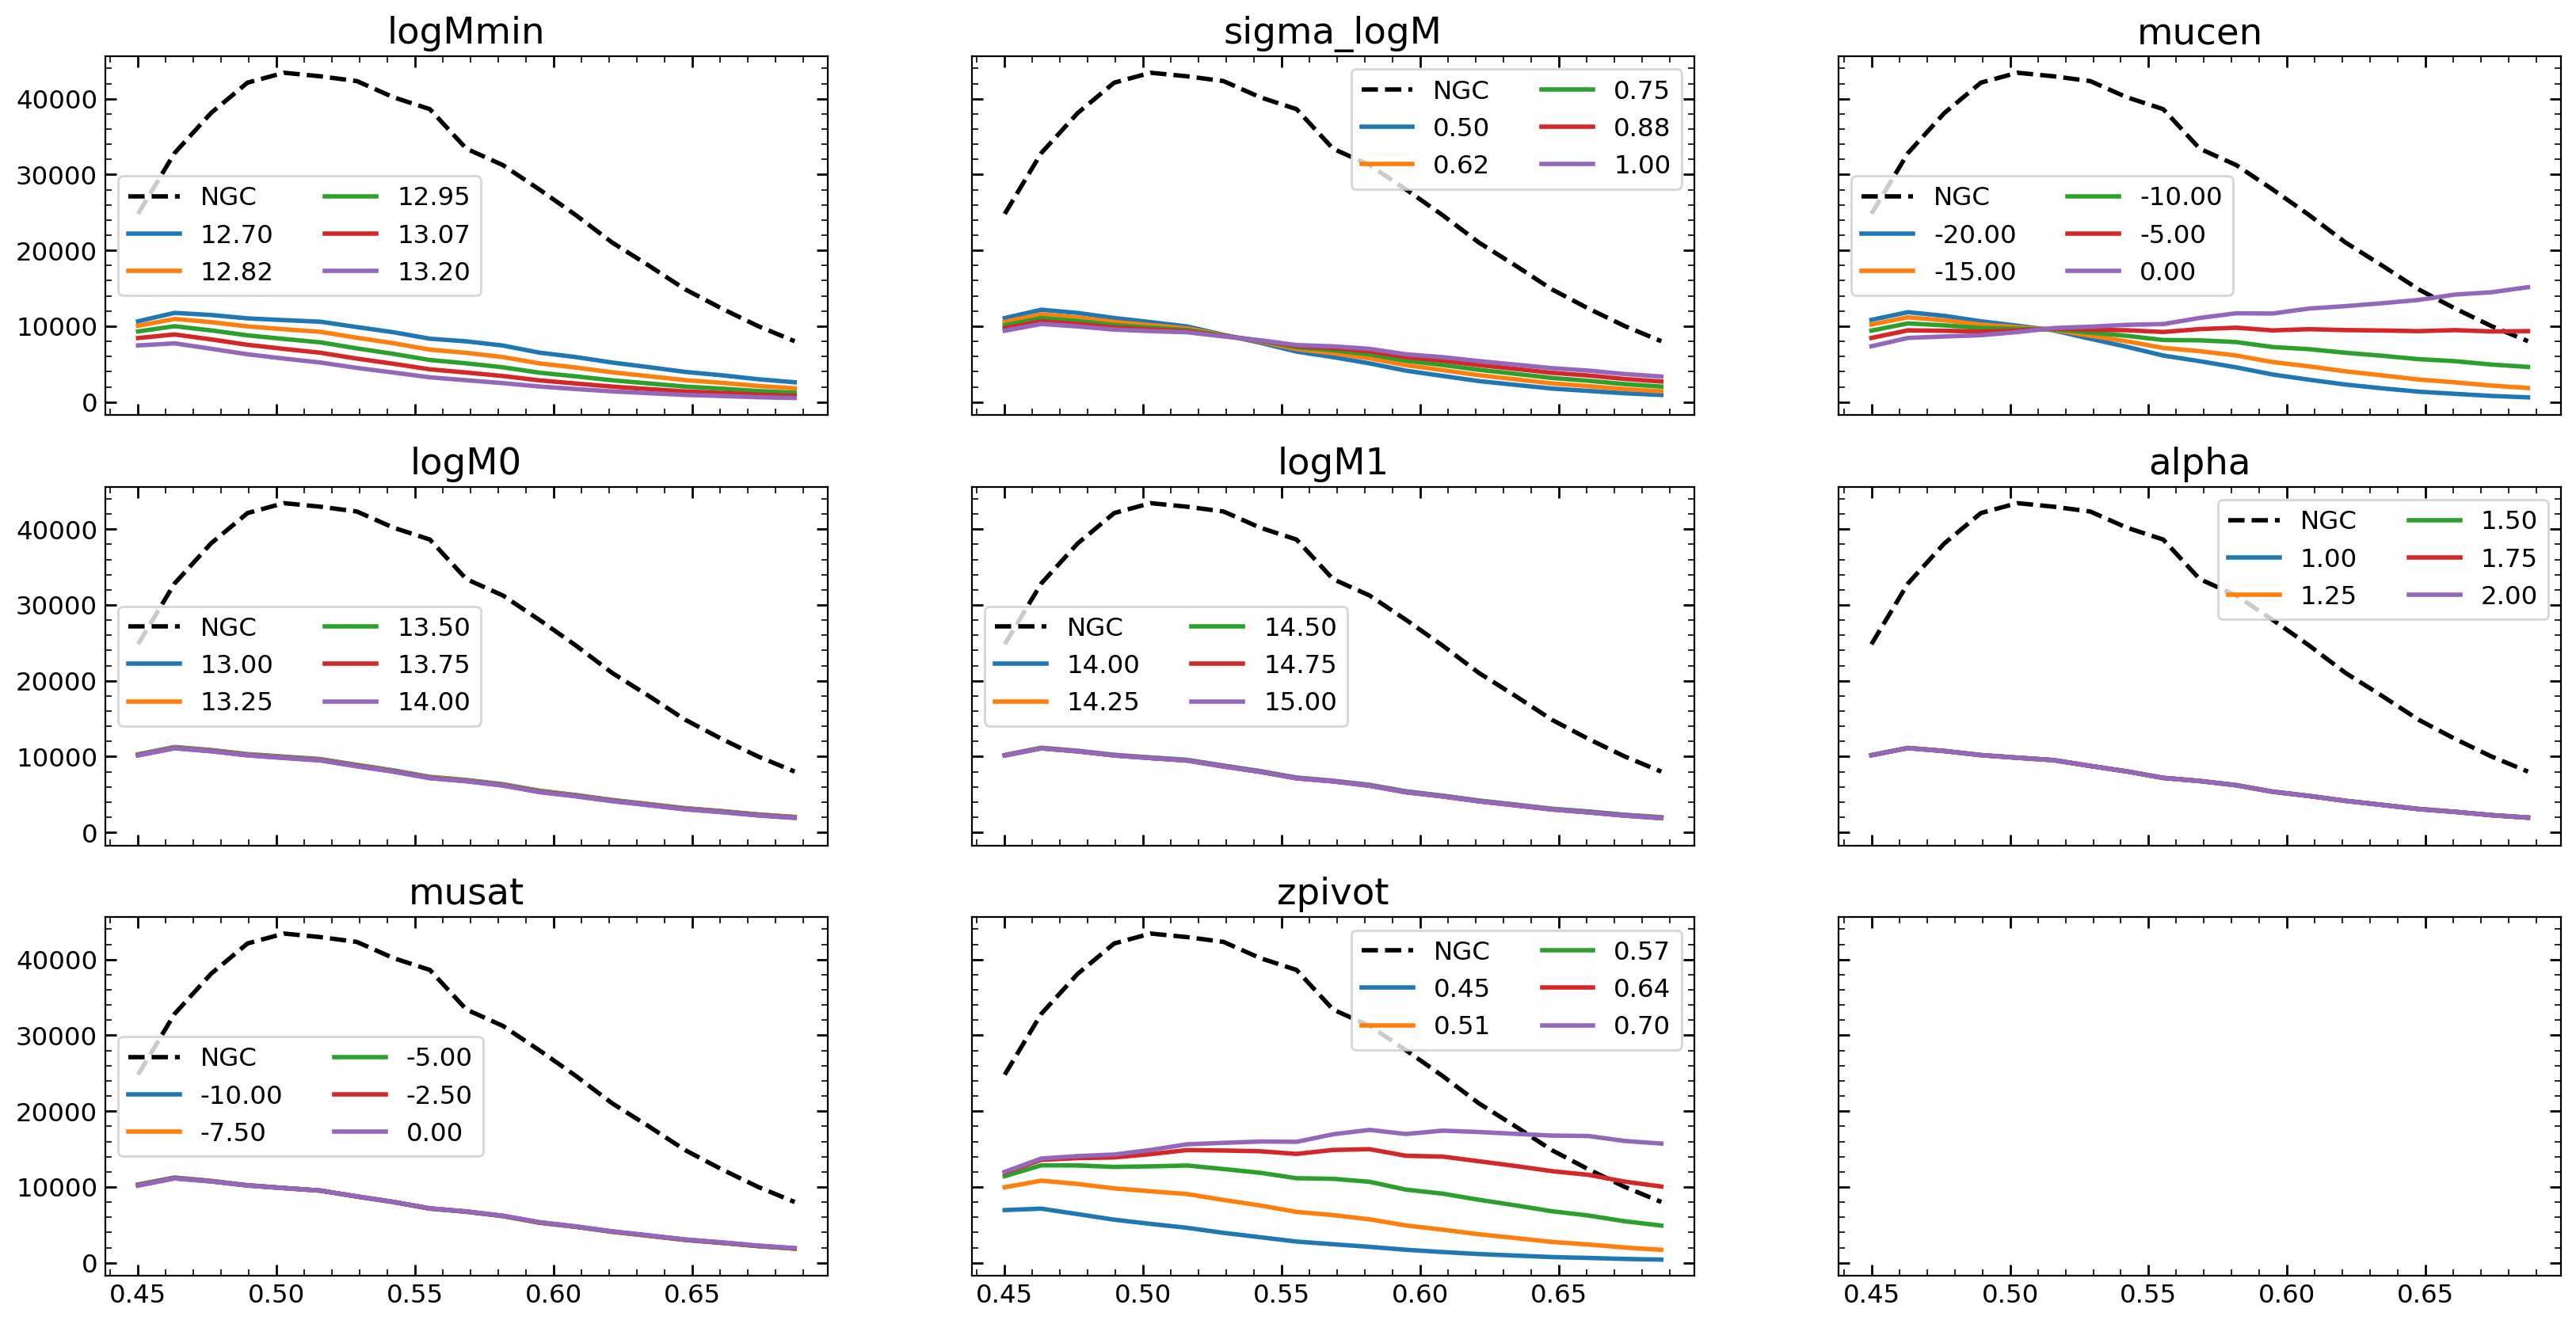

In [12]:
from copy import deepcopy
prior_range = np.array([
    (12.7, 13.2),  # logMmin
    (0.5, 1.0),  # sigma_logM
    (-20, 0),  # mucen
    (13.0, 14.0),  # logM0
    (14.0, 15.0),  # logM1
    (1, 2),  # alpha
    (-10, 0),  # musat
    (0.45, 0.7),  # zpivot
])
fid = [12.8, 0.734, -14.735, 13.655, 14.173, 1.415, 0, 0.519]

names = ['logMmin', 'sigma_logM', 'mucen', 'logM0',
         'logM1', 'alpha', 'musat', 'zpivot']

N = len(fid)
M = 5
z_bins = np.linspace(0.45, 0.7, 20)

f, axs = plt.subplots(3, N//3+1, sharex=True, sharey=True, figsize=(20, 10))
axs = axs.flatten()
for i in range(N):
    print(f'Plotting {names[i]}...')
    ax = axs[i]
    ax.plot(z_bins[:-1], ngc_hist, label='NGC', color='k', linestyle='--')

    plist = np.linspace(prior_range[i, 0], prior_range[i, 1], M)
    for v in plist:
        params = deepcopy(fid)
        params[i] = v

        ncen_hist, nsat_hist = calcH(mass, z, z_bins, params)

        ax.plot(z_bins[:-1], ncen_hist+nsat_hist, label=f'{params[i]:.2f}')
    ax.set_title(names[i])
    ax.legend(ncol=2)

In [17]:
from scipy.optimize import minimize


def objective(params):
    ncen_hist, nsat_hist = calcH(mass, z, z_bins, params)
    ntot = ncen_hist + nsat_hist
    dist = np.mean(ntot - ngc_hist * np.log(ntot))
    print(f'{dist:.4e}')
    return dist


fid = [
    13.4,  # logMmin
    0.5,   # sigma_logM
    -20,  # mucen
    13.5,  # logM0
    14.5,  # logM1
    1.1,  # alpha
    0,  # musat
    0.4  # zpivot
]
bounds = [
    (12.8, None),  # logMmin
    (0.1, None),  # sigma_logM
    (None, 0),  # mucen
    (12.8, None),  # logM0
    (12.8, None),  # logM1
    (None, None),  # alpha
    (None, 0),  # musat
    (0.45, 0.7),  # zpivot
]
result = minimize(objective, fid, method='Nelder-Mead',
                  options={'maxiter': 1000, 'disp': True},
                  bounds=bounds)

/tmp/ipykernel_484036/4110138095.py:32: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective, fid, method='Nelder-Mead',


-1.2061e+05
-1.4918e+04
-1.2441e+05
-1.1386e+05
-1.1697e+05
-1.1555e+05
-1.2046e+05
-1.2061e+05
-1.4763e+05
-1.9411e+05
-1.9603e+05
-1.5294e+05
-1.6374e+05
-1.6724e+05
-1.7617e+05
-1.8777e+05
-2.0113e+05
-2.2236e+05
-2.1863e+05
-2.0587e+05
-2.1621e+05
-2.1776e+05
-2.1918e+05
-2.2040e+05
-2.2021e+05
-2.3338e+05
-2.4466e+05
-2.3697e+05
-2.3542e+05
-2.3659e+05
-2.3978e+05
-2.4323e+05
-2.4641e+05
-2.5338e+05
-2.5189e+05
-2.5514e+05
-2.6024e+05
-2.5644e+05
-2.5761e+05
-2.5920e+05
-2.6144e+05
-2.6570e+05
-2.6194e+05
-2.6236e+05
-2.6333e+05
-2.6383e+05
-2.6265e+05
-2.6316e+05
-2.6430e+05
-2.6561e+05
-2.6563e+05
-2.6531e+05
-2.6597e+05
-2.6594e+05
-2.6603e+05
-2.6540e+05
-2.6443e+05
-2.6422e+05
-2.6485e+05
-2.6511e+05
-2.6569e+05
-2.6535e+05
-2.6451e+05
-2.6600e+05
-2.6526e+05
-2.6585e+05
-2.6545e+05
-2.6591e+05
-2.6590e+05
-2.6657e+05
-2.6691e+05
-2.6642e+05
-2.6551e+05
-2.6607e+05
-2.6655e+05
-2.6620e+05
-2.6670e+05
-2.6585e+05
-2.6624e+05
-2.6642e+05
-2.6719e+05
-2.6755e+05
-2.6744e+05
-2.6

/tmp/ipykernel_484036/4110138095.py:32: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(objective, fid, method='Nelder-Mead',


[ 1.28000000e+01  2.21932899e-01 -2.46544121e+01  1.28000080e+01
  1.28000000e+01  1.43194473e+00 -4.10194638e-07  5.54626181e-01]


(0.0, 45597.3)

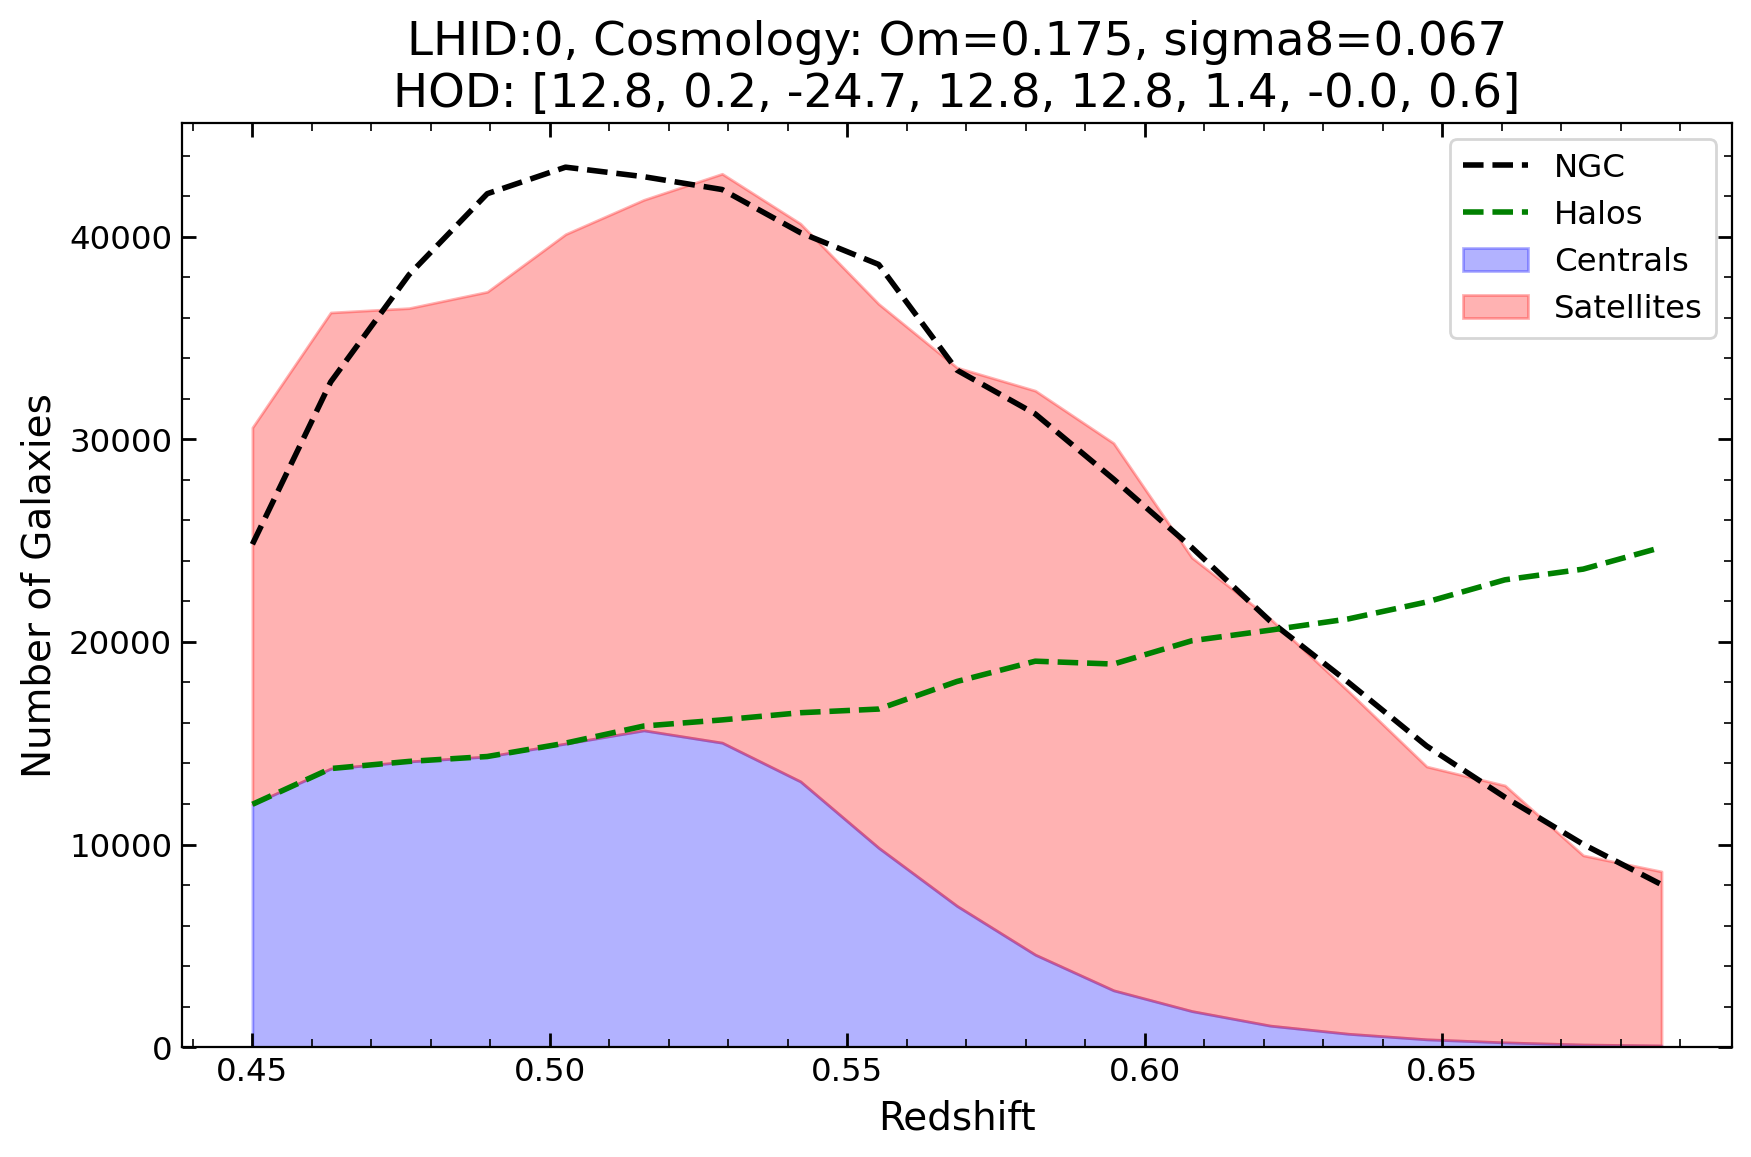

In [18]:
x0 = result.x
# x0 = list(x0[:-1]) + [13.5, 14.5, 1.1, 0, x0[-1]]
print(x0)
# x0 = [
#     13.2,
#     0.61,
#     -23,
#     13.5, 14.5, 1.1, 0,
#     0.38
# ]
f, ax = plt.subplots(figsize=(10, 6))
ax.plot(z_bins[:-1], ngc_hist,
        label='NGC', color='k', linestyle='--')
ax.plot(z_bins[:-1], halo_hist,
        label='Halos', color='g', linestyle='--')

ncen_hist, nsat_hist = calcH(mass, z, z_bins, x0)
ntot = ncen_hist + nsat_hist
ax.fill_between(z_bins[:-1], ncen_hist, label='Centrals', color='b', alpha=0.3)
ax.fill_between(z_bins[:-1], y1=ncen_hist, y2=ntot,
                label='Satellites', color='r', alpha=0.3)
ax.set(xlabel='Redshift', ylabel='Number of Galaxies')
ax.legend()


ax.set_title(
    f'LHID:{lhid}, '
    f'Cosmology: Om={cfg.nbody.cosmo[0]:.3f}, sigma8={cfg.nbody.cosmo[1]:.3f}\n'
    f"HOD: [{', '.join([f'{i:.1f}' for i in x0])}]"
)
ax.set_ylim(0)

In [42]:
', '.join(names)

'logMmin, sigma_logM, mucen, logM0, logM1, alpha, musat, zpivot'

## Run inference

In [31]:
import numpy as np
import os
from os.path import join
from tqdm import tqdm

summdir = '/anvil/scratch/x-mho1/cmass-ili/scratch/hodz'
files = os.listdir(summdir)

params = []
ncens = []
nsats = []
for file in tqdm(files):
    x = np.load(join(summdir, file))
    params.append(x['params'])
    ncens.append(x['ncen_hist'])
    nsats.append(x['nsat_hist'])

params, ncens, nsats = map(np.array, [params, ncens, nsats])

  0%|          | 0/19930 [00:00<?, ?it/s]

100%|██████████| 19930/19930 [00:22<00:00, 884.74it/s] 


In [32]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


In [33]:
x = ncens + nsats
theta = params

# Remove any rows in x that contain NaN values
valid_indices = ~np.isnan(x).any(axis=1)
x = x[valid_indices]
theta = theta[valid_indices]

print(x.shape, theta.shape)

loader = NumpyLoader(x=x, theta=theta)

(19920, 19) (19920, 13)


/tmp/ipykernel_522483/3337314921.py:6: MatplotlibDeprecationWarning: Passing label as a length 13 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(x[ind], alpha=1, label=theta[ind])


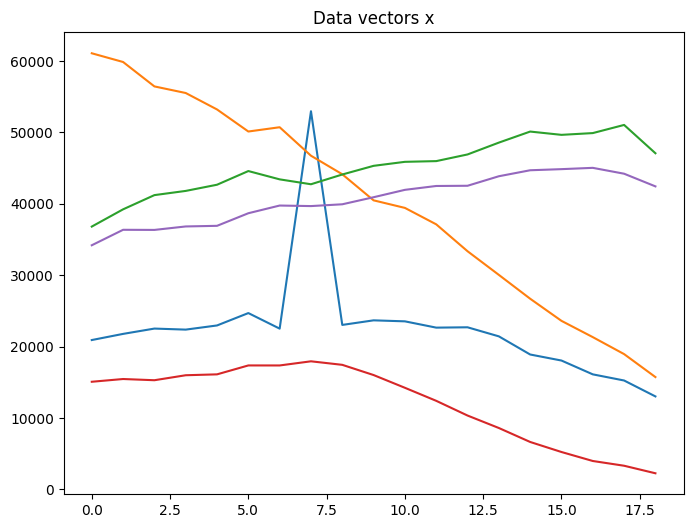

In [34]:
# plot some examples of the data
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=1, label=theta[ind])
# ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

In [35]:
# define a prior
prior = ili.utils.Uniform(
    low=theta.min(axis=0), high=theta.max(axis=0), device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(engine='NPE', model='nsf',
                             hidden_features=16, num_transforms=3),
    ili.utils.load_nde_lampe(engine='NPE', model='maf',
                             hidden_features=16, num_transforms=3),
]

# define training arguments
train_args = {
    'training_batch_size': 128,
    'learning_rate': 2e-4,
    'lr_decay_factor': 0.5

}

# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
362 epochs [09:32,  2.17s/ epochs, loss=-6.19, loss_val=-5.87, lr=3.13e-6]

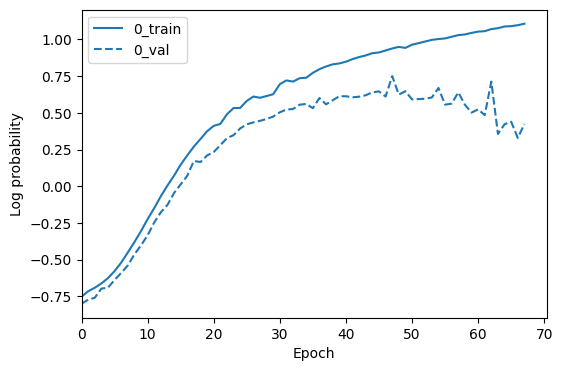

In [10]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 1000 posterior samples: 1377it [00:00, 38659.38it/s]            
/home/x-mho1/.conda/envs/2024.02-py311/cmass/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/x-mho1/.conda/envs/2024.02-py311/cmass/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/x-mho1/.conda/envs/2024.02-py311/cmass/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/x-mho1/.conda/envs/2024.02-py311/cmass/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance)

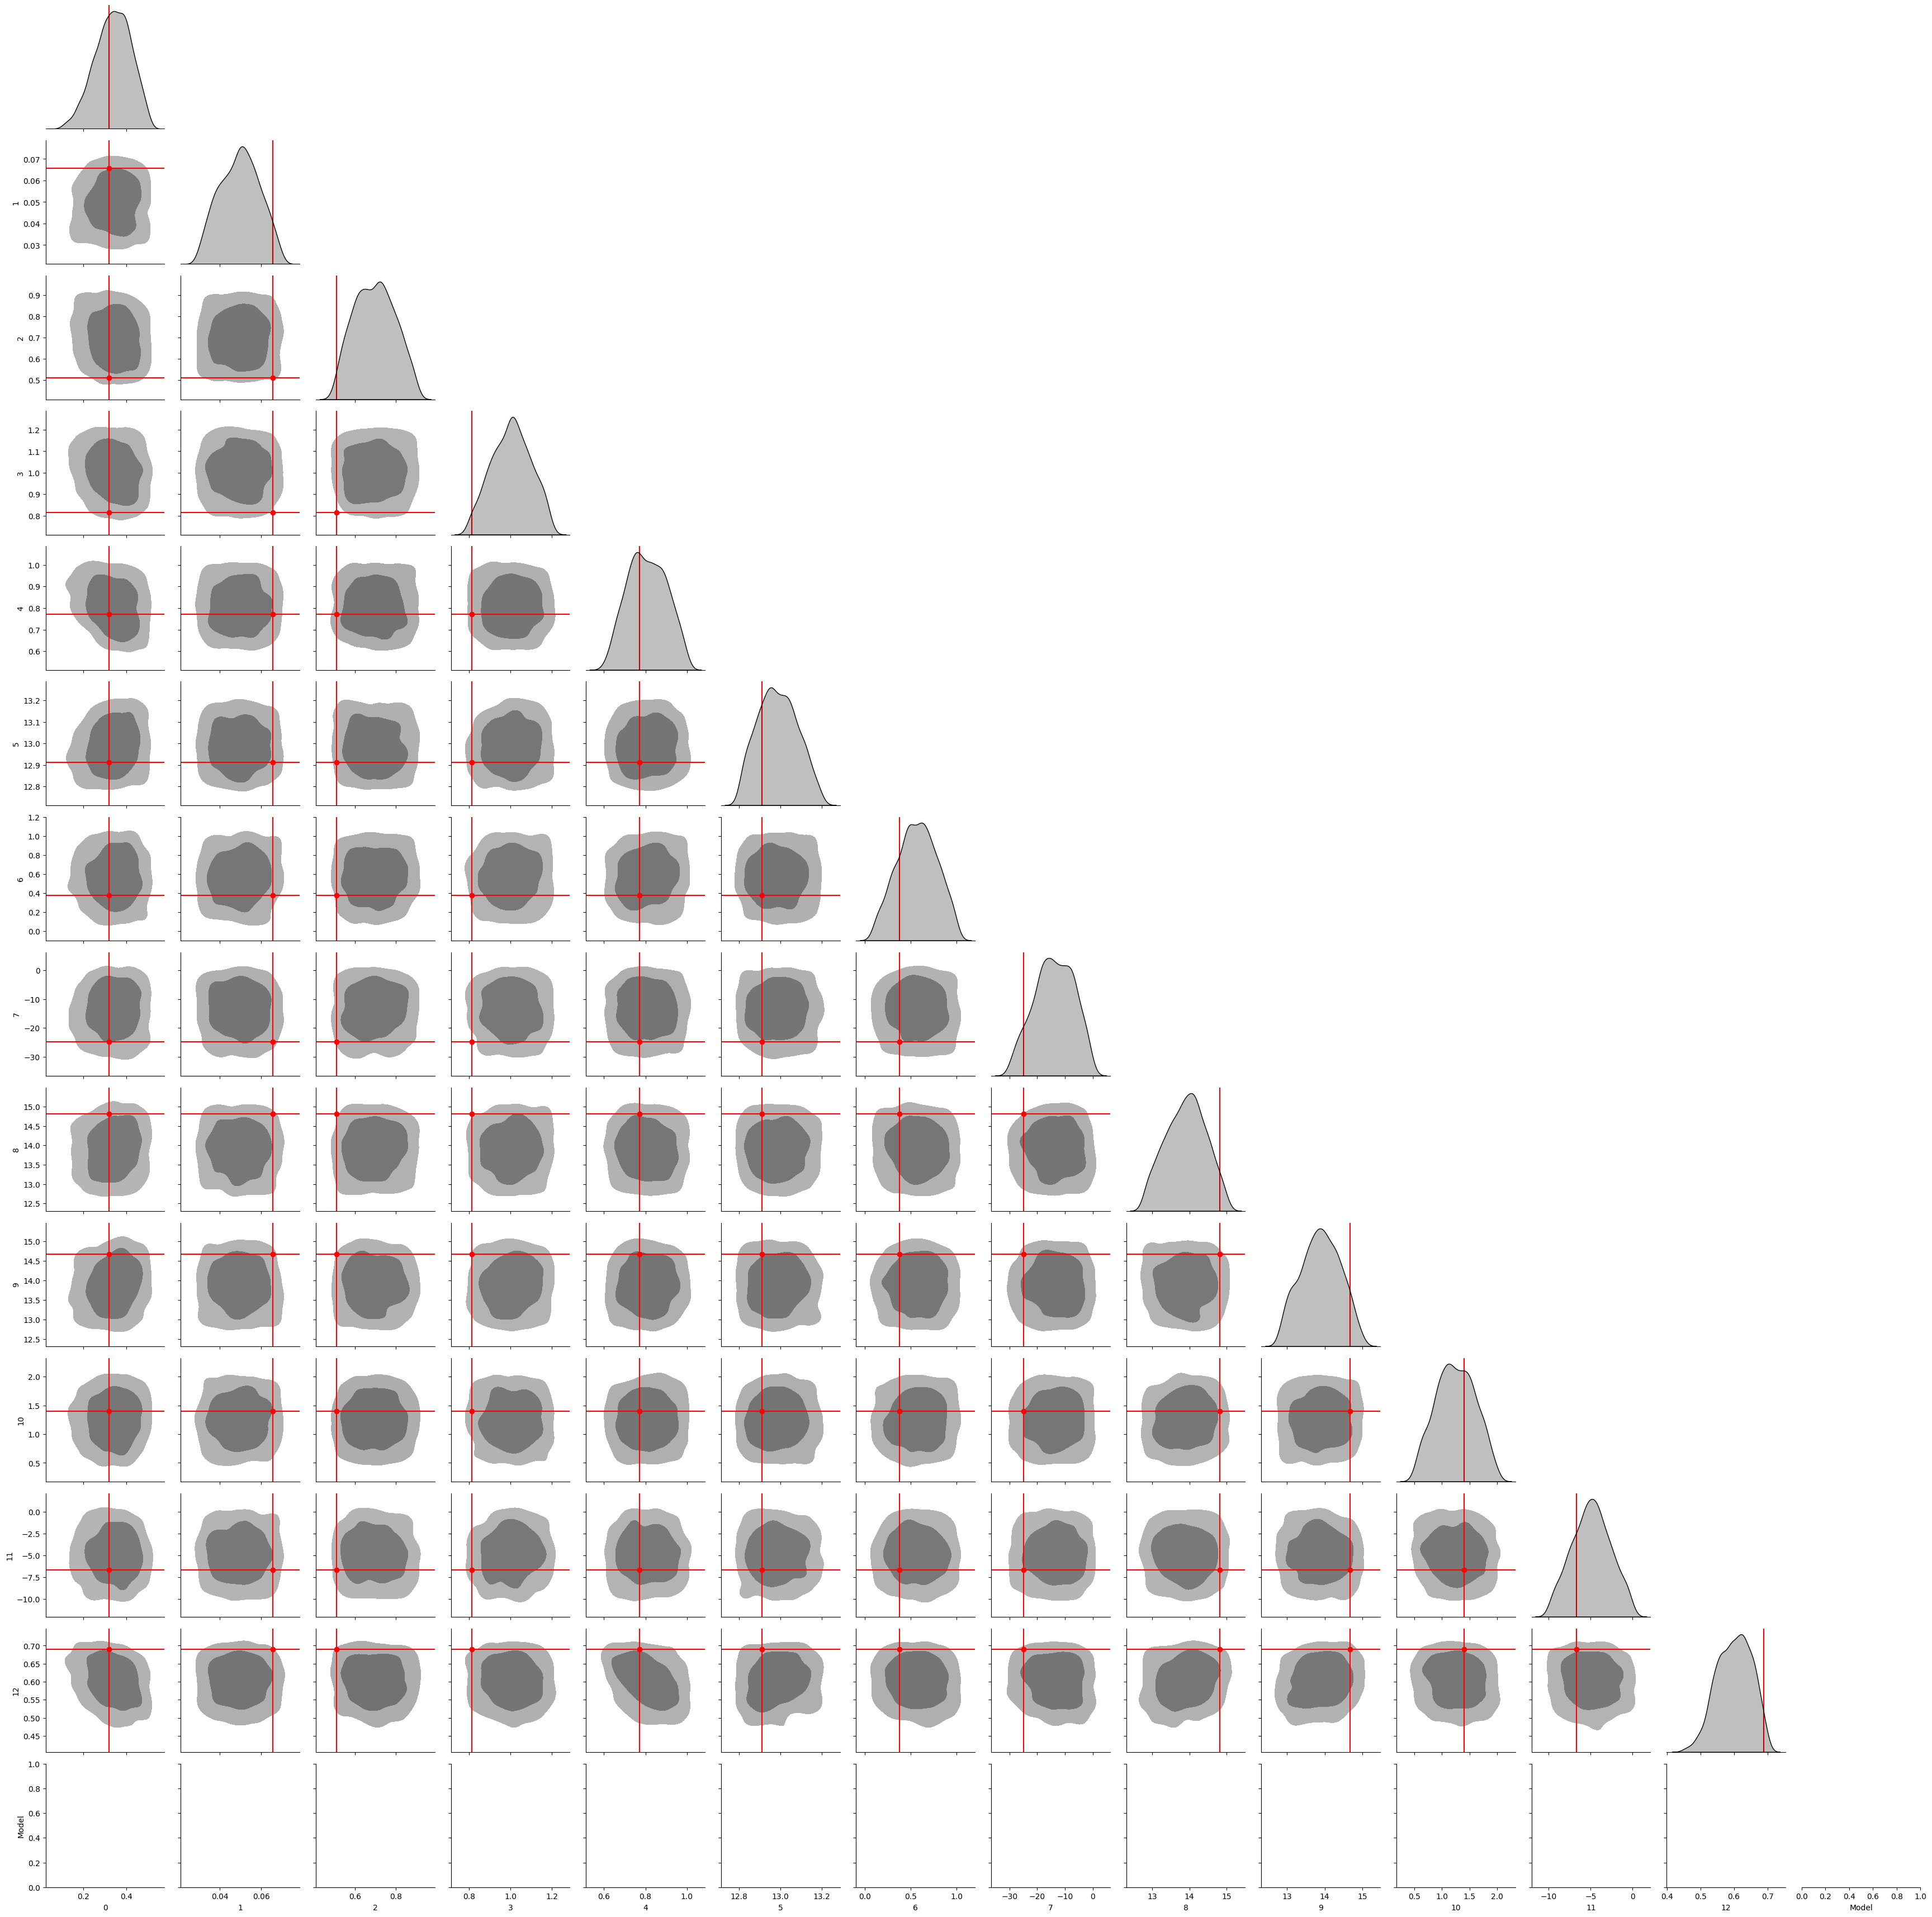

In [11]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    # labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs=x[ind], theta_fid=theta[ind],
    plot_kws=dict(fill=True)
)